# Jack’s Car Rental

---
A solution to Jack's car rental problem

In [1]:
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from jax import random
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

jnp.set_printoptions(suppress=True, linewidth=100)

In [3]:
# Discount rate
γ = 0.9
# Rate of request
λ_req_a, λ_req_b = 3, 4
# Rate of return
λ_ret_a, λ_ret_b = 3, 2

# Maximum number of cars allowed at any location
max_cars = 20
# Maximum number of cars that are allowed to be moved overnight
max_car_move = 5

# MDP:
# timestep: days
# state: number of cars at each location at the end of the day
# actions: net number of cars moved between the two locations overnight

To solve this problem, we must first determine the grid of possible values given by

$$
    p(s'_a, s'_b, r \vert s_a, s_b, a)
$$

* $\mathcal A = \{-5, -4, \ldots, 5\}$
* $\mathcal R = \left\{10, -2n\right\}$, where $n$ is the number of cars moved overnight

## Some experiments

In [4]:
S_a, S_b  = 10, 20

In [11]:
key = random.PRNGKey(314)

key_ret_a, key_req_a, key_ret_b, key_req_b = random.split(key, 4)

n_days = 500

returned_a = random.poisson(key_ret_a, λ_ret_a, (n_days,))
requested_a = random.poisson(key_req_a, λ_req_a, (n_days,))

returned_b = random.poisson(key_ret_b, λ_ret_b, (n_days,))
requested_b = random.poisson(key_req_b, λ_req_b, (n_days,))

In [12]:
def reduce_hist(state, xs):
    new_state = jnp.clip(state + xs, 0, 20)
    return new_state, new_state

### Inventory simulation

Assuming that there is no interaction between locations `a` and `b`, the following plot shows a simulation on the number of cars at each location at the end of the day.

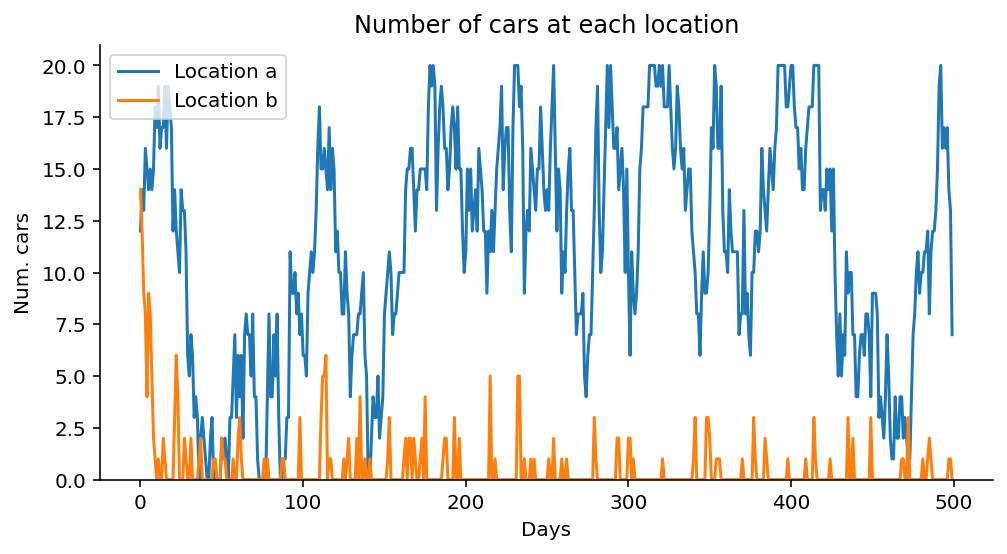

In [13]:
Δa = returned_a - requested_a
Δb = returned_b - requested_b

_, hist_a = jax.lax.scan(reduce_hist, S_a, Δa)
_, hist_b = jax.lax.scan(reduce_hist, S_b, Δb)

plt.subplots(1, 1, figsize=(8, 4))
plt.plot(hist_a, label="Location a")
plt.plot(hist_b, label="Location b")
plt.ylim(0, 21)
plt.legend()
plt.ylabel("Num. cars")
plt.xlabel("Days")
plt.title("Number of cars at each location");

## Computing probabilities

The claim is that

$$
    p(s_b' \vert s_b, a) = \text{Skellam}\left(s_b' - s_b -  a \vert \lambda_b^\text{ret}, \lambda_b^\text{req}\right) \mathbb{1}\big(0 \leq s_b' \leq 20\big)
$$

In [14]:
def prob_a(sa_prime, sa, action):
    dist = tfp.distributions.Skellam(λ_ret_a, λ_req_a)
    return dist.prob(sa_prime - sa - action) * (0 <= sa_prime) * (sa_prime <= 20)

In [15]:
sa = 3
a = 5

sa_prime_samp = sa + a + returned_a - requested_a
sa_prime_samp = (sa + a + returned_a - requested_a) * (0 <= sa_prime_samp) * (sa_prime_samp <= 20)

Computing the distribution of the number of cars at location `a` at the end of the day assuming that $s_a = 3$ and $a = 5$

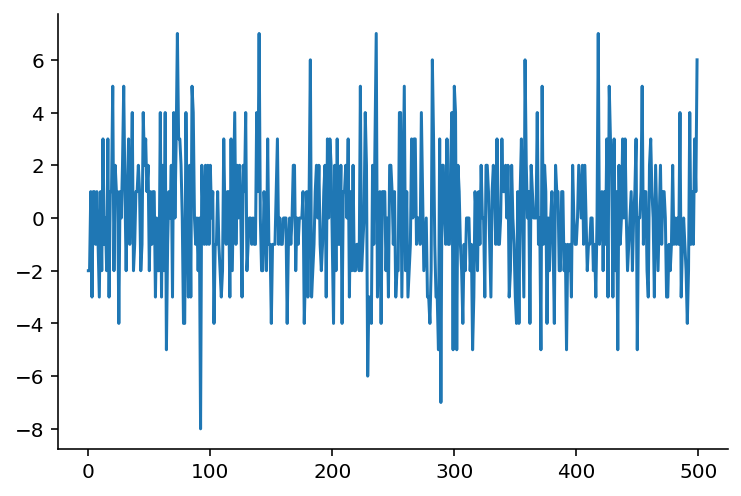

In [16]:
plt.plot(requested_a -  returned_a)

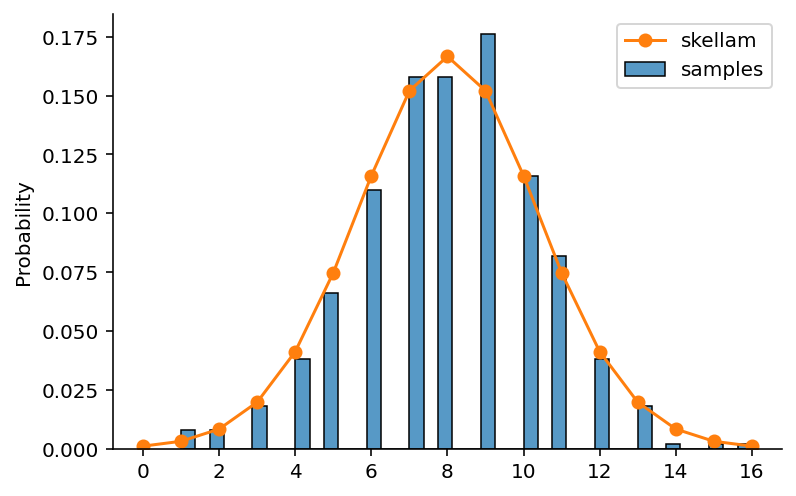

In [17]:
net_move_a = jnp.arange(0, 17).astype(float)

sns.histplot(sa_prime_samp, stat="probability", bins=40, label="samples")
plt.plot(net_move_a, prob_a(net_move_a, sa, a), c="tab:orange", marker="o", label="skellam")
plt.legend();

In [18]:
def prob_a(sa_prime, sa, action):
    """
    Probabiliy of moving `action` cars from location a -> location b
    """
    dist = tfp.distributions.Skellam(λ_ret_a, λ_req_a)
    return dist.prob(sa_prime - sa - action) * (0 <= sa_prime) * (sa_prime <= 20)

def prob_b(sb_prime, sb, action):
    """
    Probabiliy of moving `action` cars from location b -> location a
    """
    dist = tfp.distributions.Skellam(λ_ret_b, λ_req_b)
    return dist.prob(sb_prime - sb + action) * (0 <= sb_prime) * (sb_prime <= 20)

def p_move(action, sa, sb):
    return (sa >= action) * (sb >= -action)

In [19]:
sa = 1
sb = 0

actions = jnp.arange(-5, 6)
actions

DeviceArray([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5], dtype=int32)

In [20]:
for action in actions:
    val = p_move(action, sa, sb)
    print(f"{action:2}: {val}")

-5: False
-4: False
-3: False
-2: False
-1: False
 0: True
 1: True
 2: False
 3: False
 4: False
 5: False


In [21]:
arange = jnp.arange(-5, 6).astype(float)
vrange = jnp.arange(0, 21).astype(float)
req_range = jnp.arange(20).astype(float)
ret_range = jnp.arange(20).astype(float)

$$
    p(s_a', s_b', n \vert s_a, s_b, a) = \text{Skellam}(s_a' - s_a + a \vert \lambda^\text{ret}_a, \lambda^\text{req}_a) \times \text{Skellam}(s_b' - s_b - a \vert \lambda^\text{ret}_b, \lambda^\text{req}_b)
\times \text{pois}\left((n + 2a)/10, \lambda^\text{req}_a + \lambda^\text{req}_b\right)
$$

In [22]:
def p_transition_a(state_prime, state, action):
    dist = tfp.distributions.Skellam(λ_ret_a, λ_req_a)
    return dist.prob(state_prime - state + action) * (0 >= state_prime) * (state_prime <= 20)

def p_transition_b(state_prime, state, action):
    dist = tfp.distributions.Skellam(λ_ret_b, λ_req_b)
    return dist.prob(state_prime - state - action) * (0 >= state_prime) * (state_prime <= 20)

def p_move(action, sa, sb):
    return (sa >= action) * (sb >= -action)

@jax.jit
def p(sa_prime, sb_prime, n_req, sa, sb, action):
    pois = tfp.distributions.Poisson(rate=λ_req_a + λ_req_b)
    prob_req = pois.prob(n_req) * (sa + sb >= n_req)
    
    return (p_transition_a(sa_prime, sa, action) * p_transition_b(sb_prime, sb, action) *
            p_move(action, sa, sb))

In [23]:
num_params = 6

# outer-product-like vmap over each of the entires of the distribution
pv = p
for n in range(num_params):
    vals = [0 if i==n else None for i in range(num_params)]
    pv = jax.vmap(pv, vals, out_axes=-1)
    
#              sa',    sb',      n    | sa,      sb,   action
p_grid = pv(vrange, vrange, req_range, vrange, vrange, arange)
Z_grid = p_grid.sum(axis=0, keepdims=True).sum(axis=1, keepdims=True).sum(axis=2, keepdims=True)
# p_grid = jnp.nan_to_num(p_grid / Z_grid, posinf=0, neginf=0)

In [24]:
p_grid[..., 0, 1, 5].sum()

DeviceArray(0.5213302, dtype=float32)

In [25]:
array_reward =  10 * req_range[:, None] - 2 * jnp.abs(arange[None, :])
# n, action
array_reward.shape

(20, 11)

In [26]:
value_array = jnp.zeros((21, 21))
# sa', sb'
value_array.shape

(21, 21)

In [27]:
reward_value = array_reward[None, None, ...] + γ * value_array[..., None, None]
# sa', sb', n, action
reward_value.shape

(21, 21, 20, 11)

In [28]:
# ** Initial policy **
# In the initial policy we assume that we will not be moving
# cars between lots
policy = jnp.zeros((11, 21, 21)) # (action, sa, sb)
policy = policy.at[5].set(1)

# ** Initial value function **
value_array = jnp.zeros((21, 21))

Indices' naming
```
a: sa
b: sb
c: action
i: sa'
j: sb'
k: n-requested
l: n-returned
```

In [29]:
for _ in range(20):
    reward_value = array_reward[None, None, ...] + γ * value_array[..., None, None]
    value_array = jnp.einsum("cab,ijkabc,ijkc->ab", policy, p_grid, reward_value)

In [30]:
value_array.sum()

DeviceArray(1489.0033, dtype=float32)

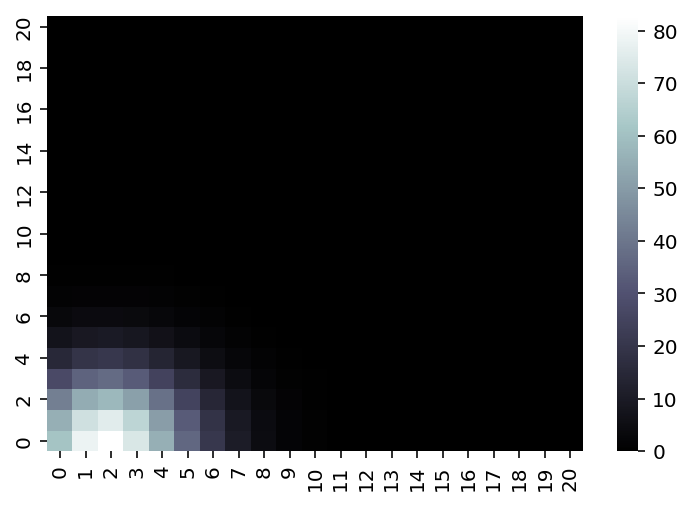

In [31]:
ax = sns.heatmap(value_array, cmap="bone")
plt.xticks(rotation=90)
ax.invert_yaxis()

## Policy improvement

$$
    v_{\pi'}(s_a, s_b) = \max_a \sum_{s_a', s_b', n} p(s_a', s_b', n_\text{req} \vert s_a, s_b, a)\left[10n_\text{req} - 2a + \gamma v_\pi(s_a', s_b')\right]
$$

In [32]:
reward_value = array_reward[None, None, ...] + γ * value_array[..., None, None]
q_improv = jnp.einsum("ijkabc,ijkc->cab", p_grid, reward_value)

In [33]:
# Update value function
value_array = q_improv.max(axis=0)

# Policy improvment
policy = jnp.zeros((11, 21, 21))
policy = jax.nn.one_hot(q_improv.argmax(axis=0), 11, axis=0)

In [34]:
jnp.set_printoptions(precision=5, linewidth=500)

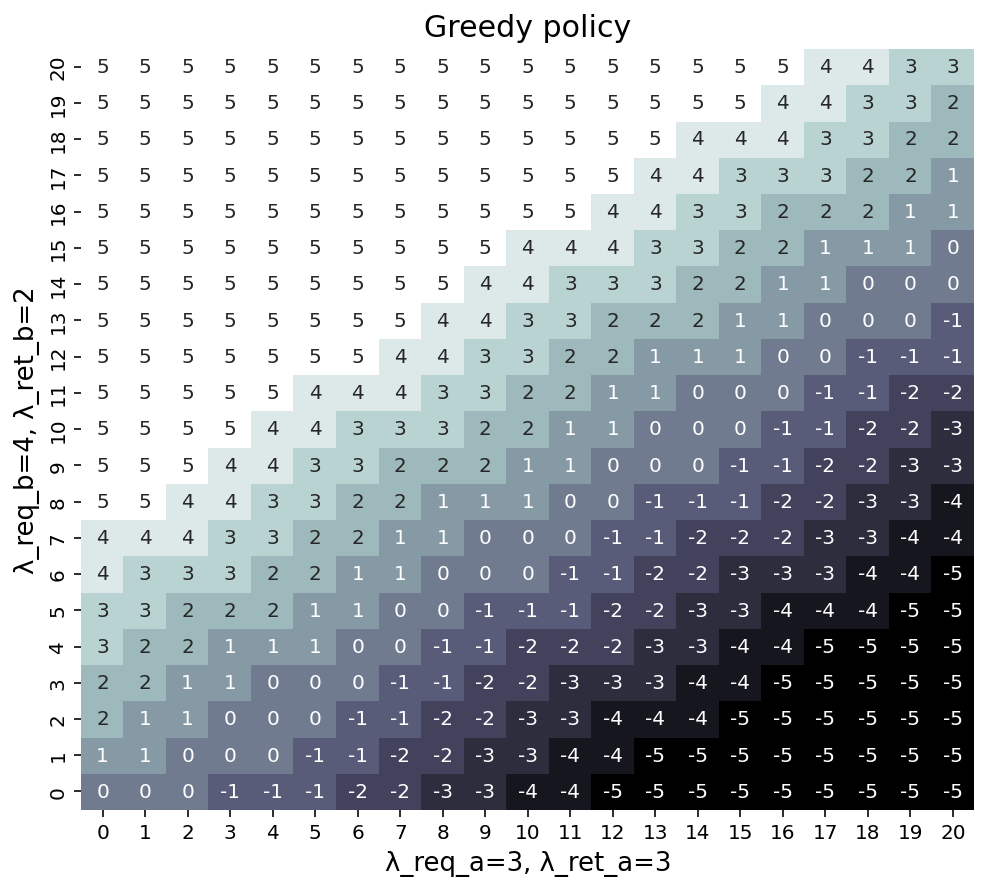

In [35]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(q_improv.argmax(axis=0) - 5, cmap="bone", annot=True, cbar=False, ax=ax)
ax.invert_yaxis()
ax.set_title("Greedy policy", fontsize=15)
ax.set_xlabel(f"{λ_req_a=}, {λ_ret_a=}", fontsize=13)
ax.set_ylabel(f"{λ_req_b=}, {λ_ret_b=}", fontsize=13);

## Second try

We will model the transition probabilities of $s_a$ and $s_b$ separately, i.e., we will compute

$$
\begin{aligned}
    &p(s_a', s_b', r \vert s_a, s_b, a) = \sum_{\phi_a, \phi_b}\sum_{\varphi_a, \varphi_b} p(s_a', s_b', r, \phi_a, \phi_b, \varphi_a, \varphi_b \vert s_a, s_b, a) \\
    &= \sum_{\phi_a, \varphi_a} p(\phi_a) p(\varphi_a) p(s_a' \vert \phi_a, \varphi_a, s_a, a) \sum_{\phi_b, \varphi_b} p(\phi_b) p(\varphi_b) p(s_b' \vert \phi_b, \varphi_b, s_b, a) p(r \vert \varphi_a, \varphi_b, a) \\
    &= \sum_{\phi_a} p(\phi_a) \sum_{\phi_b} p(\phi_b) \sum_{\varphi_a, \varphi_b} p(\varphi_a) p(\varphi_b)  p(s_a' \vert \phi_a, \varphi_a, s_a, a)  p(s_b' \vert \phi_b, \varphi_b, s_b, a) p(r \vert \varphi_a, \varphi_b, a)
\end{aligned}
$$

Where

* $p(\phi_a) = \text{Pois}(\phi_a \vert \lambda^\text{ret}_a)$
* $p(\varphi_a) = \text{Pois}(\varphi_a \vert \lambda^\text{req}_a)$

* $p(\phi_b) = \text{Pois}(\phi_b \vert \lambda^\text{ret}_b)$
* $p(\varphi_b) = \text{Pois}(\varphi_b \vert \lambda^\text{req}_b)$

* $p(s_a' \vert \phi_a, \varphi_a, s_a, a) = \mathbb{1}(s_b' = s_a - a + \phi_a - \varphi_a) \mathbb{1}(0 \leq s_a' \leq 20)$
* $p(s_b' \vert \phi_b, \varphi_b, s_b, a) = \mathbb{1}(s_b' = s_b + a + \phi_b - \varphi_b) \mathbb{1}(0 \leq s_b' \leq 20)$
* $p(r \vert \varphi_a, \varphi_b, a) = \mathbb{1}(r = 10 (\varphi_a + \varphi_b) - 2 \vert a \vert)$

In [5]:
def pr_transition_a(n_ret, n_req, n_cars, action):
    """
    Parameters
    ----------
    action: int
        [-5, 5] Number of cars from A -> B
    """
    n_cars_next = n_cars - action + n_ret - n_req
    
    p_ret = tfd.Poisson(λ_ret_a).prob(n_ret)
    p_req = tfd.Poisson(λ_req_a).prob(n_req)
    
    return p_ret * p_req * (n_cars_next >= 0) * (n_cars_next <= 20)

def pr_transition_b(n_ret, n_req, n_cars, action):
    n_cars_next = n_cars + action + n_ret - n_req
    
    p_ret = tfd.Poisson(λ_ret_b).prob(n_ret)
    p_req = tfd.Poisson(λ_req_b).prob(n_req)
    
    return p_ret * p_req * (n_cars_next >= 0) * (n_cars_next <= 20)

In [6]:
from jax.experimental import loops

In [7]:
from itertools import product

max_elements = 20
@jax.jit
def value_function(state, action_array, value_grid, discount=0.9):
    state_a, state_b = state
    action = action_array.argmax() - 5
    with loops.Scope() as s:
        s.expected_reward = 0.0
        for n_ret_a in s.range(max_elements):
            for n_req_a in s.range(max_elements):
                for n_ret_b in s.range(max_elements):
                    for n_req_b in s.range(max_elements):
                        sa_prime = state_a - action + n_ret_a - n_req_a
                        sb_prime = state_b + action + n_ret_b - n_req_b

                        pr_a = pr_transition_a(n_ret_a, n_req_a, state_a, action)
                        pr_b = pr_transition_b(n_ret_b, n_req_b, state_b, action)

                        reward = 10. * (n_req_a + n_req_b) - 2 * jnp.abs(action)
                        is_valid_move = (sa_prime >= 0) * (sa_prime <= 20) *(sb_prime >= 0) * (sb_prime <= 20)
                            
                        reward_step = pr_a * pr_b * (reward + discount * value_grid[sa_prime, sb_prime]) * is_valid_move
                        s.expected_reward = s.expected_reward + reward_step 
    return s.expected_reward

In [8]:
# ** Initial policy **
# In the initial policy we assume that we will not be moving
# cars between lots
policy = jnp.zeros((11, 21, 21)) # (action, sa, sb)
policy = policy.at[5].set(1)
value_array = jnp.zeros((21, 21))

In [9]:
%%time
value_function(jnp.asarray([5, 10]), 0, value_array).block_until_ready()

CPU times: user 1.02 s, sys: 0 ns, total: 1.02 s
Wall time: 1.98 s


DeviceArray(52.438465, dtype=float32)

In [10]:
vmap_value_function = jax.vmap(value_function, (1, 1, None, None), out_axes=-1)
vmap_value_function = jax.vmap(vmap_value_function, (2, 2, None, None), out_axes=-1)
# vmap_value_function = jax.vmap(vmap_value_function, (None, 0, None, None))

In [11]:
vrange = jnp.mgrid[:21, :21]
arange = jnp.arange(-5, 6)

In [38]:
value_array = vmap_value_function(vrange, policy, value_array, 0.9)

In [39]:
value_array

DeviceArray([[ 10.93772 ,  19.032042,  29.359646,  40.88554 ,  52.482643,  63.37295 ,  73.24079 ,
               82.0906  ,  90.04907 ,  97.248726, 103.791306, 109.74784 , 115.165276, 120.06861 ,
              124.44798 , 128.2231  , 131.17712 , 132.81337 , 132.17834 , 127.7916  , 118.01029 ],
             [ 14.624455,  25.394487,  39.114025,  54.4241  ,  69.85094 ,  84.38655 ,  97.61722 ,
              109.54002 , 120.311516, 130.09155 , 139.00896 , 147.14932 , 154.56894 , 161.29729 ,
              167.31674 , 172.51605 , 176.5949  , 178.87497 , 178.06047 , 172.14085 , 158.9032  ],
             [ 17.901844,  31.042095,  47.7713  ,  66.45707 ,  85.33957 , 103.20916 , 119.567184,
              134.39268 , 147.8601  , 160.1468  , 171.38931 , 181.68323 , 191.0903  , 199.63947 ,
              207.30258 , 213.93599 , 219.1571  , 222.11101 , 221.1709  , 213.82156 , 197.31015 ],
             [ 20.446964,  35.430374,  54.5163  ,  75.875755,  97.54157 , 118.154564, 137.14236 ,
              154

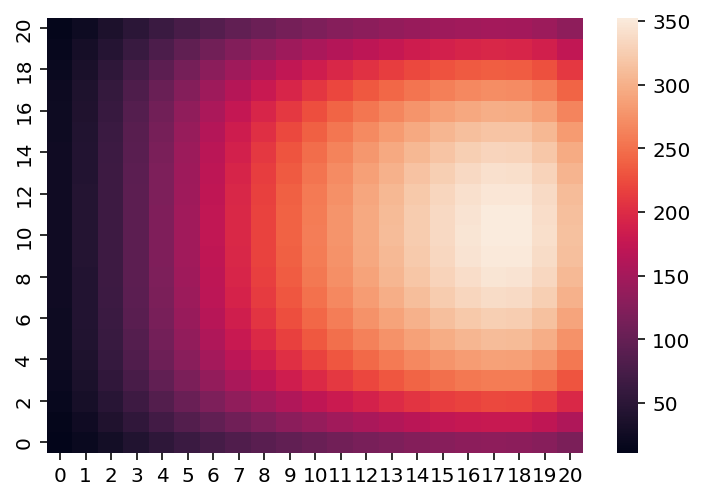

In [40]:
ax = sns.heatmap(value_array)
ax.invert_yaxis()

In [41]:
improv_value_function = jax.vmap(value_function, (1, None, None, None), out_axes=-1)
improv_value_function = jax.vmap(improv_value_function, (2, None, None, None), out_axes=-1)
improv_value_function = jax.vmap(improv_value_function, (None, 0, None, None), out_axes=-1)

In [42]:
q_improv = improv_value_function(vrange, arange, value_array, 0.9).block_until_ready()

In [43]:
q_improv.argmax(axis=0) - 5

DeviceArray([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0,